## import the important libraries

In [1]:
import os                                                                                  # Operating System library for file operations
import re                                                                                  # Regular Expression library for text processing
import cv2                                                                                 # OpenCV library for image processing
import tqdm
import random                                                                              # Library for generating random numbers or shuffling sequences
import string                                                                              # Library for string operations
import pickle                                                                              # Library for serializing and deserializing Python objects
from PIL import Image
import numpy as np                                                                         # Numerical computing library
import pandas as pd                                                                        # Data manipulation and analysis library
import tensorflow as tf                                                                    # Deep learning framework
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, to_categorical, Sequence                               # Utilities for Keras models
from keras.layers import Embedding, Input, Dense, Dropout, concatenate, LSTM, Flatten, add # Keras layers
from keras.models import Model, load_model                                                 # Keras models
from keras.preprocessing.text import Tokenizer                                             # Text preprocessing
from keras.preprocessing.image import load_img, img_to_array                               # Image preprocessing
from keras.preprocessing.sequence import pad_sequences                                     # Sequence preprocessing
from keras.applications.inception_v3 import InceptionV3, preprocess_input                  # InceptionV3 model for image feature extraction

c:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Create CNN model to extract the features

In [11]:
def get_features_encoder():

    incept = InceptionV3(input_shape=(224,224,3), include_top=False, weights='imagenet')  # Use the pre-trained CNN model (InceptionV3)
    
    print(len(incept.layers))                                                             # Print the number of layers in the InceptionV3 model
    
    for layer in incept.layers:                                                           # Set all layers in the InceptionV3 model to non-trainable
        layer.trainable = False
    
    flatten = Flatten()(incept.output)                                                    # Flatten the output of the InceptionV3 model
    layer1 = Dense(units=10, activation='relu')(flatten)                                  # Add a dense layer with 10 units and ReLU activation
    layer2 = Dense(units=2048, activation='relu')(layer1)                                 # Add another dense layer with 2048 units and ReLU activation
    features_encoder = Model(incept.input, layer2)                                        # Create a model that maps input images to the output of the second dense layer

    return features_encoder                                                               # return the full model

In [12]:
features_encoder = get_features_encoder()               # Get the feature encoder model using the defined function

print(len(features_encoder.layers))                     # Print the number of layers in the feature encoder model

features_encoder.summary()                              # Display a summary of the feature encoder model, showing its architecture and parameters

311
314
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normaliz

In [13]:
features_encoder.save('features_encoder.h5')            # Save the feature encoder model to a file named 'features_encoder.h5'

In [2]:
features_encoder = load_model('features_encoder.h5')    # Load the feature encoder model from the file 'features_encoder.h5'

## Load the images of Flicker8k dataset and Extract the features

In [15]:
datadir=r'Flickr8k\Images'  # path of image's folder

features=dict()                                         # Create features dictionary to save the features of the images with their ids as keys

for img in (os.listdir(datadir)):                   # Loop in image's folder to get each image name
    
    img_path=os.path.join(datadir,img)                  # Join folder path to the name of each image 
    image=cv2.imread(img_path)                          # Read each image by its path
    image=cv2.resize(image,(224,224))                   # Resize each image to (224,224)
    image=img_to_array(image)                           # Ronvert each image to array
    image=image.reshape((-1,224,224,3))                 # Reshape each image 
    image=preprocess_input(image)                       # Preprocess each image to inceptionV3 model
    feature=features_encoder.predict(image,verbose=0)   # Predict the feature of each image
    image_id=img.split('.')[0]                          # Get the id of each image by its name
    features[image_id]=feature                          # Save each feature of image by its id in the dictionary

In [16]:
pickle.dump(features,open('features.pkl','wb'))         # Save the features of images

In [7]:
file = open('features.pkl', 'rb')                       # Open the file 'features.pkl' for reading in binary mode

features = pickle.load(file)                            # Load the data from the file using pickle and store it in the variable 'features'

## Load the captions from the text file

In [8]:
def read_file(file_path):                               # Function for read images IDs and its captions
    
    file = open(file_path, 'r')                         # Open the file specified by file_path for reading
    lines = file.readlines()                            # Read all lines from the file
    string_lines = [str(i).strip('\n') for i in lines]  # Remove the newline character ('\n') from each line and convert to string
    string_lines = string_lines[1:]                     # Exclude the first line (header) from the list of string lines
    img_ids = [i.split(',')[0].split('.')[0] for i in string_lines] # Extract image IDs and captions from the string lines
    captions = [y.split(',')[1] for y in string_lines]
    
    return img_ids, captions                            # Return the extracted image IDs and captions

In [9]:
captions_file=r'Flickr8k\captions.txt' # Read the captions and the image's id of each caption 
img_ids, captions=read_file(captions_file)

In [10]:
print(img_ids[0])                                      # Print the first element of the list img_ids

print(captions[0])                                     # Print the first element of the list captions

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [11]:
mapping = dict()                                       # Create an empty dictionary to store mappings between image IDs and captions

for i, y in zip(img_ids, captions):                    # Iterate through pairs of image IDs and captions
    if i not in mapping:                               # Check if the image ID is not already in the mapping dictionary
        mapping[i] = []                                # If not, create a new entry with the image ID as the key and an empty list as the value
    mapping[i].append(y)                               # Append the current caption to the list of captions for the corresponding image ID

In [12]:
mapping[img_ids[0]]                                    # Retrieve the list of captions associated with the first image ID in the img_ids list

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Preprocessing for each caption

In [13]:
def preprocessing(caption):                            # For cleaning caption
    
    caption = re.sub("[^A-Za-z]", " ", caption)        # Remove non-alphabetic characters and replace with space
    caption = re.sub("(\?|!)+", " ", caption)          # Remove consecutive question marks or exclamation marks and replace with space
    caption = re.sub("\s\d+\s", "", caption)           # Remove single digits surrounded by spaces
    caption = re.sub("(\.|\,)+", "", caption)          # Remove periods and commas
    caption = re.sub("^\s+", "", caption)              # Remove leading and trailing white spaces
    caption = re.sub("\s+$", "", caption)
    
    for word in caption.split():                       # Iterate through each word in the caption
        
        if word not in string.punctuation:             # Check if the word is not a punctuation mark
            new_word = word.lower()                    # Make all words in lowercase
            caption.replace(word, new_word)            # Replace the original word with the lowercase version
            
        else:
            caption.replace(word, '')                  # Remove punctuation marks from the caption
    
    caption = "startsen " + " ".join([word for word in caption.split() if len]) + " endsen"   # Add start and end tokens to the caption
    
    return caption                                     # Return the caption after preprocessing

In [14]:
for key, captions in mapping.items():                 # Iterate through each key-value pair in the mapping dictionary
    
    for i in range(len(captions)):                    # Iterate through each caption associated with the current key
        
        caption = preprocessing(captions[i])          # Preprocess the current caption using the preprocessing function
        captions[i] = caption                         # Replace the original caption with the preprocessed one

In [15]:
mapping[img_ids[0]] 

['startsen A child in a pink dress is climbing up a set of stairs in an entry way endsen',
 'startsen A girl going into a wooden building endsen',
 'startsen A little girl climbing into a wooden playhouse endsen',
 'startsen A little girl climbing the stairs to her playhouse endsen',
 'startsen A little girl in a pink dress going into a wooden cabin endsen']

## Create list of all captions in mapping dictionary

In [16]:
all_captions = []                                     # Create an empty list to store all captions

for key in mapping:                                   # Iterate through each key in the mapping dictionary 
    for caption in mapping[key]:                      # Iterate through each caption associated with the current key
        all_captions.append(caption)                  # Append the current caption to the list of all captions

In [17]:
print(len(all_captions))                              # Print the total number of captions collected

40455


## Tokenize and Convert each caption to sequence 

In [18]:
tokenizer = Tokenizer()                               # Initialize a Tokenizer object and fit it on all captions
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1           # Determine the vocabulary size by adding 1 to the number of unique words in the tokenizer's word index

max_length = max(len(caption.split()) for caption in all_captions) # Determine the maximum length of captions by finding the length of the longest caption


sequences = tokenizer.texts_to_sequences(all_captions)# Convert the captions to sequences of integers

sequences = pad_sequences(sequences)                  # Pad the sequences to ensure uniform length

In [19]:
print("vocab size : " + str(vocab_size))              # Print the vocabulary size
print("max length : " + str(max_length))              # Print maximum caption length

print(sequences[0])                                   # Print the sequence of integers representing the first caption in the sequences

vocab size : 8276
max length : 35
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    2    1   43    4    1   88  172    7  115   51    1  388
   12  384    4   28 5003  669    3]


In [30]:
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))     #save the tokenizer of captions

In [31]:
 file=open('tokenizer.pkl','rb')                      #load the tokenizer of captions from the saved file
tokenizer=pickle.load(file)    

In [32]:
pickle.dump(max_length,open('max_length.pkl','wb'))   #save the max length of captions

In [33]:
 file=open('max_length.pkl','rb')                     #load the max length of captions from the saved file
max_length=pickle.load(file)   

## Train and Test split

In [20]:
images_ids=list(mapping.keys())

images_ids_train=images_ids[:7000]
images_ids_test=images_ids[7000:]

train_captions=all_captions[:35000]
test_captions=all_captions[35000:]

## Create data generator

In [21]:
features_train_lst=[]                                      # create train features list
features_test_lst = []                                     # create test features list

for key in images_ids_train:                               # get image ID
    for i in range(5):                                     # multiply each feature by 5
        features_train_lst.append(features[key])           # append features to train features list

for key in images_ids_test:                                # get image ID
    for i in range(5):                                     # multiply each feature by 5
        features_test_lst.append(features[key])            # append features to test features list

In [22]:
print(len(features_train_lst))                             # ptint number of features

35000


In [23]:
print(len(features_test_lst))                              # ptint number of features

5455


In [24]:
lengths_of_caps_train = []                                 # create a list of train captions length
lengths_of_caps_test=[]                                    # create a list of test captions length

for caption in train_captions:                             # get image captions
    length_caption = len(caption.split()) - 1              # calculate each caption length
    lengths_of_caps_train.append(length_caption)           # append each caption length

for caption in test_captions:                              # get image captions
    length_caption=len(caption.split()) - 1                # calculate each caption length
    lengths_of_caps_test.append(length_caption)            # append each caption length

In [25]:
print(lengths_of_caps_train)                               # print all train captions leangth

[18, 8, 9, 10, 13, 10, 16, 19, 13, 9, 20, 13, 21, 14, 10, 13, 15, 18, 12, 12, 10, 9, 12, 12, 13, 8, 8, 13, 12, 12, 17, 11, 9, 16, 12, 9, 15, 7, 14, 15, 13, 20, 8, 20, 20, 8, 10, 9, 16, 8, 11, 8, 6, 13, 14, 17, 12, 14, 13, 12, 9, 13, 12, 15, 20, 13, 8, 12, 8, 12, 15, 14, 12, 15, 9, 14, 12, 11, 16, 14, 14, 19, 10, 18, 10, 6, 12, 14, 17, 11, 8, 10, 7, 8, 10, 9, 12, 12, 8, 6, 13, 12, 10, 8, 10, 11, 17, 8, 12, 6, 17, 9, 11, 12, 13, 13, 16, 9, 11, 7, 16, 16, 19, 13, 20, 13, 13, 11, 19, 10, 19, 16, 8, 15, 19, 10, 16, 15, 3, 13, 10, 12, 16, 7, 13, 10, 9, 11, 12, 17, 12, 8, 12, 10, 10, 11, 11, 11, 7, 10, 14, 9, 17, 10, 18, 14, 24, 8, 9, 17, 10, 14, 11, 20, 11, 13, 12, 12, 7, 12, 16, 18, 17, 12, 3, 8, 7, 9, 6, 13, 10, 7, 13, 9, 10, 12, 9, 12, 6, 8, 11, 13, 9, 11, 8, 8, 3, 7, 13, 10, 14, 11, 8, 19, 15, 11, 11, 13, 14, 9, 14, 10, 7, 11, 16, 12, 12, 14, 13, 13, 11, 13, 10, 11, 11, 9, 9, 9, 10, 8, 11, 10, 16, 6, 11, 12, 13, 9, 11, 7, 20, 11, 11, 14, 8, 11, 13, 12, 23, 14, 13, 10, 10, 9, 10, 11, 7, 1

In [26]:
print(lengths_of_caps_test)                              # print all test captions leangth

[12, 14, 10, 15, 18, 18, 5, 6, 14, 13, 19, 16, 12, 11, 18, 10, 10, 7, 11, 10, 12, 16, 13, 10, 8, 14, 13, 12, 16, 12, 7, 8, 9, 9, 6, 21, 19, 10, 6, 5, 15, 13, 10, 12, 12, 9, 9, 14, 6, 9, 10, 4, 12, 7, 10, 14, 11, 12, 25, 9, 11, 8, 16, 11, 14, 10, 12, 9, 15, 13, 9, 11, 8, 7, 8, 13, 9, 13, 10, 13, 6, 16, 6, 7, 10, 4, 15, 11, 13, 10, 12, 8, 5, 10, 13, 10, 8, 8, 8, 7, 4, 7, 10, 5, 11, 16, 8, 9, 7, 15, 7, 15, 8, 12, 15, 12, 12, 9, 7, 12, 14, 7, 12, 15, 13, 11, 14, 5, 8, 12, 7, 11, 18, 16, 16, 11, 7, 8, 14, 18, 9, 6, 8, 9, 13, 9, 11, 12, 9, 8, 9, 9, 5, 6, 9, 5, 19, 9, 9, 10, 13, 10, 12, 13, 10, 14, 21, 7, 10, 9, 16, 11, 14, 17, 7, 13, 6, 15, 15, 12, 11, 10, 11, 17, 11, 11, 10, 10, 7, 17, 13, 14, 15, 11, 15, 14, 11, 7, 10, 10, 13, 8, 9, 8, 9, 8, 9, 13, 7, 9, 13, 8, 16, 15, 22, 13, 7, 7, 7, 7, 7, 13, 14, 8, 13, 15, 3, 16, 13, 13, 9, 13, 16, 12, 8, 11, 11, 15, 13, 13, 12, 15, 9, 15, 8, 8, 8, 24, 20, 17, 10, 7, 7, 13, 9, 8, 17, 6, 12, 11, 14, 15, 10, 9, 8, 10, 13, 13, 14, 5, 11, 12, 18, 16, 10, 8

In [27]:
len(features_train_lst)==len(lengths_of_caps_train)      # insure that train features and aptions are equal

True

In [28]:
len(features_test_lst)==len(lengths_of_caps_test)        # insure that test features and aptions are equal

True

In [29]:
sum(lengths_of_caps_train)                               # calculate all lengths of train captions

397862

In [30]:
sum(lengths_of_caps_test)                                # calculate all lengths of test captions

62423

In [31]:
all_features_train_lst=[]                                # create a list of all train features
all_features_test_lst=[]                                 # create a list of all train features

for i in range(len(features_train_lst)):                 # create loop indicate length of train features list
    for j in range(lengths_of_caps_train[i]):            # create loop indicate length of train captions
        all_features_train_lst.append(features_train_lst[i])   # append all features after process all train data  

for i in range(len(features_test_lst)):                  # create loop indicate length of train features list
    for j in range(lengths_of_caps_test[i]):             # create loop indicate length of test captions
        all_features_test_lst.append(features_test_lst[i])     # append all features after process all test data

In [32]:
all_features_train_lst[0]==all_features_train_lst[58]    # check after calculation the train features

array([[ True,  True, False, ...,  True, False, False]])

In [35]:
all_features_test_lst[0]==all_features_test_lst[69]      # check after calculation the test features

array([[ True, False, False, ...,  True,  True, False]])

In [36]:
in_seqs_train=[]                                         # create a list of in-sequance train data
out_seqs_train=[]                                        # create a list of in-sequance test data

for cap in train_captions:                               # loop for each train caption 
    seq=tokenizer.texts_to_sequences([cap])[0]           # convert text to sequance
    for i in range(1,len(seq)):                          # Iterate through each word in the sequence
        in_seq_train=seq[:i]                             # indicate input sequance
        out_seq_train=seq[i]                             # indicate output sequance
        in_seqs_train.append(in_seq_train)               # append input sequance
        out_seqs_train.append(out_seq_train)             # indicate output sequance

In [37]:
in_seqs_test=[]                                          # create a list of in-sequance train data
out_seqs_test=[]                                         # create a list of in-sequance test data

for cap in test_captions:                                # loop for each train caption
    seq=tokenizer.texts_to_sequences([cap])[0]           # convert text to sequance
    for i in range(1,len(seq)):                          # Iterate through each word in the sequence
        in_seq_test=seq[:i]                              # indicate input sequance
        out_seq_test=seq[i]                              # indicate output sequance
        in_seqs_test.append(in_seq_test)                 # append input sequance
        out_seqs_test.append(out_seq_test)               # indicate output sequance

In [38]:
in_sequences_train=[]                                    # create pad-sequance list for in-sequance train data

for in_seq in in_seqs_train:                             # iterate eash sequance in in-sequance train data
    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]  # pad-sequance to max length
    in_sequences_train.append(in_seq)                    # append padded-sequance to the list

In [39]:
in_sequences_test=[]                                     # create pad-sequance list for in-sequance test data

for in_seq in in_seqs_test:                              # iterate eash sequance in in-sequance test data
    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]  # pad-sequance to max length
    in_sequences_test.append(in_seq)                     # append padded-sequance to the list

In [40]:
out_sequences_train=[]                                   # create pad-sequance list for out-sequance train data

for out_seq in out_seqs_train:                           # loop in each out-sequance train data
    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0] # apply one-hot-encoder to out-sequance
    out_sequences_train.append(out_seq)                  # append out-sequance after apply 'to_categorical'

In [41]:
out_sequences_test=[]                                    # create pad-sequance list for out-sequance test data

for out_seq in out_seqs_test:                            # loop in each out-sequance test data
    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]  # apply one-hot-encoder to out-sequance
    out_sequences_test.append(out_seq)                   # append out-sequance after apply 'to_categorical'

## Create the model

In [37]:
inputs1=Input(shape=(2048,))                                           # Define the input layer for image features
features_encoder1=Dropout(0.4)(inputs1)                                # Apply dropout to the input layer for regularization
features_encoder2=Dense(256,activation='relu')(features_encoder1)      # Add another dense layer with 256 units and ReLU activation function



inputs2=Input(shape=(max_length,))                                     # Define the input layer for sequences (captions)
sequences_encoder1=Embedding(vocab_size,256,mask_zero=True)(inputs2)   # Apply an embedding layer to convert sequences into dense vectors of fixed size
sequences_encoder2=Dropout(0.4)(sequences_encoder1)                    # Apply dropout to the embedding layer for regularization
sequences_encoder3=LSTM(256,return_sequences=True)(sequences_encoder2) # Apply LSTM layer to process the sequences



merge_layer=add([features_encoder2,sequences_encoder3])                # Merge the outputs of the two encoders
decoder1=Dense(256,activation='relu')(merge_layer)                     # Add a dense layer with 256 units and ReLU activation function to merge layer
flatten_layer=Flatten()(decoder1)                                      # Flatten the output of the decoder
outputs=Dense(vocab_size,activation='softmax')(flatten_layer)          # Add dense layer with softmax activation function to produce output probabilities


model=Model(inputs=[inputs1,inputs2],outputs=outputs)                  # Create a model with inputs and outputs

model.compile(                                                         # Compile the model
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()                                                        # Display a summary of the model architecture and parameters


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2118656   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_1[0][0]']             
                                                                                             

In [59]:
x1=np.array(all_features_train_lst[:1024*70])
x1=tf.reshape(x1, (-1, 2048))
x2=np.array(in_sequences_train[:1024*70])
y=np.array(out_sequences_train[:1024*70])

In [53]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

model.fit(x=(x1,x2),y=y,batch_size=32,
          epochs=25,callbacks=[earlystopping])

Epoch 1/25


2240/2240 [==============================] - 1485s 660ms/step - loss: 4.7069 - accuracy: 0.2426
Epoch 2/25
2240/2240 [==============================] - 1478s 660ms/step - loss: 3.7741 - accuracy: 0.2974
Epoch 3/25
2240/2240 [==============================] - 1474s 658ms/step - loss: 3.3061 - accuracy: 0.3236
Epoch 4/25
2240/2240 [==============================] - 1475s 658ms/step - loss: 2.9513 - accuracy: 0.3545
Epoch 5/25
2240/2240 [==============================] - 1475s 658ms/step - loss: 2.6561 - accuracy: 0.3902
Epoch 6/25
2240/2240 [==============================] - 1473s 658ms/step - loss: 2.4182 - accuracy: 0.4236
Epoch 7/25
2240/2240 [==============================] - 1475s 659ms/step - loss: 2.2258 - accuracy: 0.4550
Epoch 8/25
2240/2240 [==============================] - 1473s 657ms/step - loss: 2.0552 - accuracy: 0.4835
Epoch 9/25
2240/2240 [==============================] - 1473s 657ms/step - loss: 1.8990 - accuracy: 0.5125
Epoch 10/25
2240/2240 [============

In [54]:
model.save('model1.h5')

C:\Users\3tia Al Hasawy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
model=load_model('model1.h5')

In [56]:
x1_t=np.array(all_features_test_lst[:1024*10])
x1_t=tf.reshape(x1_t, (-1, 2048))
x2_t=np.array(in_sequences_test[:1024*10])
y_t=np.array(out_sequences_test[:1024*10])

In [57]:
model.evaluate((x1_t,x2_t),y_t)

320/320 [==============================] - 475s 1s/step - loss: 8.7975 - accuracy: 0.2870


[8.79746150970459, 0.2870117127895355]

In [42]:
def predict_feature(img_path):
    #read each image by its path
    image=cv2.imread(img_path)
    #resize each image to (224,224)
    image=cv2.resize(image,(224,224))
    #convert each image to array
    image=img_to_array(image)
    #reshape each image 
    image=image.reshape((-1,224,224,3))
    #preprocess each image to inceptionV3 model
    image=preprocess_input(image)
    #predict the feature of each image
    feature=features_encoder.predict(image,verbose=0) 
    feature_lst=[feature]
    feature_arr=np.array(feature_lst)   
    feature_arr=tf.reshape(feature_arr, (-1, 2048))
    return feature_arr

In [43]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None
def predict_caption(model, feature, tokenizer, max_length):
    in_text = "startsen"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endsen':
            break
            
    return in_text 

In [44]:
def show_image_from_path(image_path):
    img = Image.open(image_path)
    # Plot the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 136ms/step
Predicted caption: startsen a man and a baby are in a baby in a field up to the air endsen


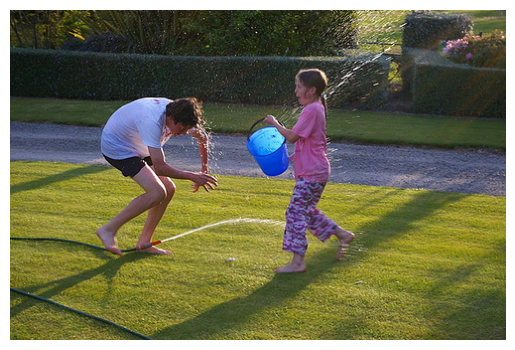

In [47]:
img_path=r'Flickr8k\Images\299181827_8dc714101b.jpg'
feature=predict_feature(img_path)
cap=predict_caption(model,feature,tokenizer,max_length)
print(f"Predicted caption: {cap}")
show_image_from_path(img_path)

1/1 [==============================] - 0s 220ms/step
Predicted caption: startsen a little girl in a pink dress going into a wooden cabin endsen


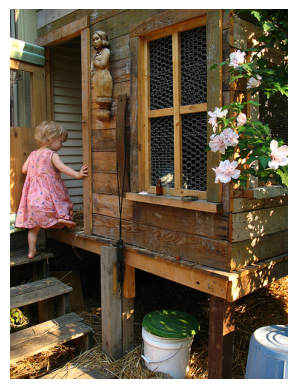

In [48]:
img_path=r'Flickr8k\Images\1000268201_693b08cb0e.jpg'
feature=predict_feature(img_path)
cap=predict_caption(model,feature,tokenizer,max_length)
print(f"Predicted caption: {cap}")
show_image_from_path(img_path)

1/1 [==============================] - 0s 131ms/step
Predicted caption: startsen a black dog and a white dog with brown spots are staring at each other in the street endsen


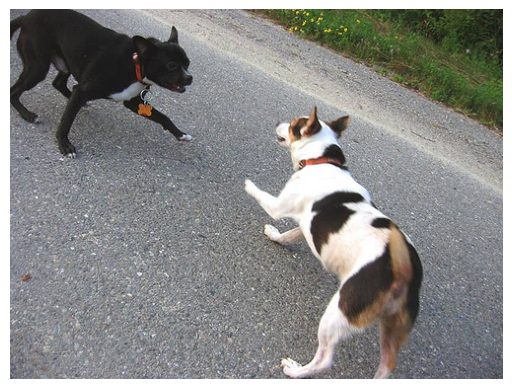

In [50]:
img_path=r'Flickr8k\Images\1001773457_577c3a7d70.jpg'
feature=predict_feature(img_path)
cap=predict_caption(model,feature,tokenizer,max_length)
print(f"Predicted caption: {cap}")
show_image_from_path(img_path)

1/1 [==============================] - 0s 125ms/step
Predicted caption: startsen a little girl is sitting in front of a large painted rainbow endsen


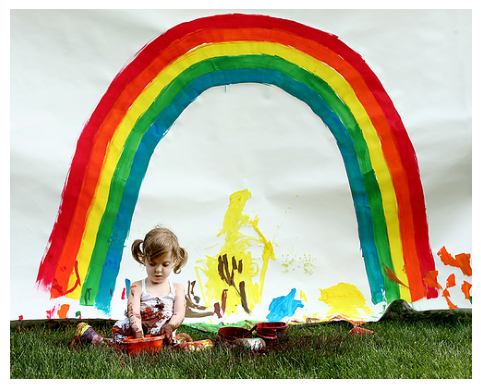

In [52]:
img_path=r'Flickr8k\Images\1002674143_1b742ab4b8.jpg'
feature=predict_feature(img_path)
cap=predict_caption(model,feature,tokenizer,max_length)
print(f"Predicted caption: {cap}")
show_image_from_path(img_path)